# Google Colab Notebook
# Candidate: Diksha Ballav
# Repository: ds_diksha_ballav
# Access: Anyone with the link can view




## Imports & Setup



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Part A — Data Preparation
## 1️) Load datasets

In [2]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

## 2️) Basic data checks

In [3]:
summary = {
    "trades_rows": trades.shape[0],
    "trades_columns": trades.shape[1],
    "sentiment_rows": sentiment.shape[0],
    "sentiment_columns": sentiment.shape[1],
    "trades_missing": trades.isna().sum().sum(),
    "sentiment_missing": sentiment.isna().sum().sum(),
    "trades_duplicates": trades.duplicated().sum(),
    "sentiment_duplicates": sentiment.duplicated().sum()
}

pd.DataFrame(summary, index=["Value"]).T


,Value
trades_rows,211224
trades_columns,16
sentiment_rows,2644
sentiment_columns,4
trades_missing,0
sentiment_missing,0
trades_duplicates,0
sentiment_duplicates,0


## 3️) Convert timestamps & align by date

In [4]:
# Convert timestamps to daily date
trades["date"] = pd.to_datetime(trades["Timestamp"], unit="ms").dt.date
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date


## 4) Create key daily trader metrics

In [5]:
daily_trader_metrics = trades.groupby(["Account", "date"]).agg(
    daily_pnl=("Closed PnL", "sum"),
    trades_per_day=("Trade ID", "count"),
    avg_trade_size_usd=("Size USD", "mean"),
    buy_ratio=("Side", lambda x: (x == "BUY").mean())
).reset_index()


## 5) Merge with Fear & Greed index

In [6]:
merged_df = daily_trader_metrics.merge(
    sentiment[["date", "classification", "value"]],
    on="date",
    how="left"
)


## Part B — Analysis
## 6) Focus on Fear vs Greed days only

In [7]:
fg_df = merged_df[merged_df["classification"].isin(["Fear", "Greed"])]

## 7) Performance comparison: Fear vs Greed

In [8]:
performance_summary = fg_df.groupby("classification").agg(
    avg_daily_pnl=("daily_pnl", "mean"),
    win_rate=("daily_pnl", lambda x: (x > 0).mean()),
    avg_trades_per_day=("trades_per_day", "mean"),
    avg_trade_size=("avg_trade_size_usd", "mean"),
    avg_buy_ratio=("buy_ratio", "mean")
)

performance_summary


,avg_daily_pnl,win_rate,avg_trades_per_day,avg_trade_size,avg_buy_ratio
classification,,,,,
Fear,209372.662205,0.93750,4183.46875,5926.522723,0.459352
Greed,99675.516731,0.84375,1134.03125,5839.310974,0.495780


## 8) Chart: Average PnL by sentiment

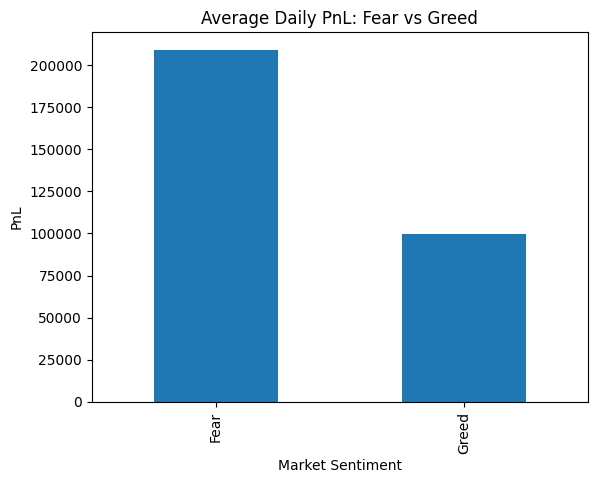

In [9]:
performance_summary["avg_daily_pnl"].plot(kind="bar")
plt.title("Average Daily PnL: Fear vs Greed")
plt.ylabel("PnL")
plt.xlabel("Market Sentiment")
plt.show()


## 9) Behavioral comparison (trade frequency & bias)

In [10]:
behavior_summary = fg_df.groupby("classification").agg(
    avg_trades=("trades_per_day", "mean"),
    avg_buy_ratio=("buy_ratio", "mean")
)

behavior_summary


,avg_trades,avg_buy_ratio
classification,,
Fear,4183.46875,0.459352
Greed,1134.03125,0.495780


## Trader Segmentation
##Segment 1: Frequent vs Infrequent traders

In [11]:
median_trades = fg_df["trades_per_day"].median()

fg_df["frequency_segment"] = np.where(
    fg_df["trades_per_day"] >= median_trades,
    "Frequent",
    "Infrequent"
)

segment_performance = fg_df.groupby(
    ["frequency_segment", "classification"]
).agg(
    avg_pnl=("daily_pnl", "mean"),
    win_rate=("daily_pnl", lambda x: (x > 0).mean())
)

segment_performance


/tmp/ipython-input-1698882904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fg_df["frequency_segment"] = np.where(


avg_pnl  win_rate
frequency_segment classification                         
Frequent          Fear            272361.063580  0.956522
                  Greed           281689.454396  1.000000
Infrequent        Fear             48402.303137  0.888889
                  Greed            28452.671557  0.782609

## Segment 2: Consistent vs Inconsistent winners

In [12]:
trader_consistency = fg_df.groupby("Account").agg(
    pnl_std=("daily_pnl", "std"),
    avg_pnl=("daily_pnl", "mean")
).reset_index()

median_std = trader_consistency["pnl_std"].median()

trader_consistency["consistency_segment"] = np.where(
    trader_consistency["pnl_std"] <= median_std,
    "Consistent",
    "Inconsistent"
)

trader_consistency.head()


,Account,pnl_std,avg_pnl,consistency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1.594697e+06,800114.909989,Inconsistent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2.481039e+03,18853.086574,Consistent
2,0x271b280974205ca63b716753467d5a371de622ab,1.992469e+04,15882.044216,Consistent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,7.880372e+04,66157.740843,Inconsistent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,4.539380e+04,84313.992027,Consistent


## Part C — Actionable Output
## Strategy rules derived from data

In [13]:
strategy_rules = pd.DataFrame({
    "Scenario": [
        "Fear days – high activity traders",
        "Greed days – directional traders"
    ],
    "Recommended Action": [
        "Reduce leverage, keep trade size constant, allow higher frequency",
        "Reduce long bias, trade selectively, avoid overconfidence"
    ]
})

strategy_rules


,Scenario,Recommended Action
0,Fear days – high activity traders,"Reduce leverage, keep trade size constant, all..."
1,Greed days – directional traders,"Reduce long bias, trade selectively, avoid ove..."


## Predictive label (next-day profitability bucket)

In [14]:
fg_df = fg_df.sort_values(["Account", "date"])
fg_df["next_day_profitable"] = (
    fg_df.groupby("Account")["daily_pnl"].shift(-1) > 0
).astype(int)

fg_df[["daily_pnl", "trades_per_day", "buy_ratio", "next_day_profitable"]].head()


,daily_pnl,trades_per_day,buy_ratio,next_day_profitable
0,-3.275059e+05,462,0.300866,1
1,1.927736e+06,3356,0.468415,0
2,2.060745e+04,320,0.453125,1
3,1.709873e+04,3533,0.432494,0
6,1.793160e+03,5,0.600000,1
